In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import glob 
import os

import re, nltk, spacy, string

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

pd.set_option('display.max_columns', 50)

In [90]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' %re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text


nlp = spacy.load('en')

def lemmatizer(text):
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    s = " ".join(sent)
    return s.replace('-PRON-', '')

In [91]:
s="I love weeds and sucking lolis afh f f mR% u 5p;n ;"
s=clean_text(s)
s=lemmatizer(s)

s

'i love weed and sucking lolis afh f f mr u  '

In [71]:
df = pd.read_csv("~/Desktop/HOP/Data/HR/HR_Amazon.csv")
#df.set_index('name', inplace=True)
#df = df[df.columns[0:51]]

In [72]:
df['total_years_of_experience'].mean()


5.658979999999999

In [73]:
df[df['total_years_of_experience'] <= 2]

,Unnamed: 0,name,age,gender,description,source_company,source_role,current_title,current_company,current_company_location,from,to,prev_title_1,prev_company_1,prev_exp_location_1,prev_exp_from_1,prev_exp_to_1,prev_exp_duration_months_1,prev_exp_duration_years_1,prev_title_2,prev_company_2,prev_exp_location_2,prev_exp_from_2,prev_exp_to_2,prev_exp_duration_months_2,...,prev_exp_from_5,prev_exp_to_5,prev_exp_duration_months_5,prev_exp_duration_years_5,total_months_of_experience,total_years_of_experience,has_phd,major_phd,institution_phd,phd_start_date,phd_end_date,has_masters,major_masters,institution_masters,masters_start_date,masters_end_date,has_bachelors,major_bachelors,institution_bachelors,bachelors_start_date,bachelors_end_date,major_other,institution_other,other_start_date,other_end_date
1,Regie Dela Cueva,Regie Dela Cueva,38.0,Male,Regie Dela Cueva is a Sales Manager at NETSUIT...,Amazon,HR,Sales Manager,NETSUITE INC,"Frankfurt am Main, Hessen, Germany",2016-06-01 00:00:00,NaN,Human Resources Recruiter,Amazon.com Inc.,"Frankfurt am Main, Hessen, Germany",2017-07-01 00:00:00,NaN,NaN,NaN,Senior Recruiting Specialist,Zalando SE,"Munich Area, Germany",2009-08-01 00:00:00,2010-06-01 00:00:00,10.0,...,NaN,NaN,NaN,NaN,10.0,0.83,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Safia Khan,Safia Khan,28.0,Female,Data-driven innovation that impacts and improv...,Amazon,HR,Sr. Human Resources,Amazon.com Inc.,Greater Los Angeles Area,2019-11-01 00:00:00,NaN,Adjunct Professor of Management,Chaminade University of Honolulu,Remote,2018-01-01 00:00:00,NaN,NaN,NaN,HR Employee Engagement and Communication,Warner Bros. Entertainment Group of Companies,"Burbank, Califronia",2016-08-01 00:00:00,NaN,NaN,...,2017-04-01 00:00:00,2018-08-01 00:00:00,16.0,1.0,23.0,1.92,False,NaN,NaN,NaN,NaN,True,NaN,Claremont Graduate University,2015.0,2017.0,True,NaN,Oregon State University,2011.0,2014.0,NaN,NaN,NaN,NaN
6,Alex Golod,Alex Golod,56.0,Male,Alex Golod is the founder and president of Fus...,Amazon,HR,Founder and President,Fusion Software Solutions,"Northbrook, Illinois",2007-01-01 00:00:00,NaN,Advisor and Angel Investor,Mirow,Greater New York City Area,2018-11-01 00:00:00,NaN,NaN,NaN,Strategic Advisor and Investor,Blip.fm,"San Francisco, California",2018-11-01 00:00:00,NaN,NaN,...,2017-11-01 00:00:00,NaN,NaN,NaN,0.0,0.00,False,NaN,NaN,NaN,NaN,True,IT Project Management,GEORGE WASHINGTON UNIVERSITY,2000.0,2003.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Audrey Mondragon,Audrey Mondragon,27.0,Female,Human Resources Specialist at Amazon Web Services,Amazon,HR,Human Resources Specialist,Amazon.com Inc.,"Palo Alto, California",2017-08-01 00:00:00,NaN,Area Manager,Amazon.com Inc.,"Tracy, California",2016-02-01 00:00:00,2016-10-01 00:00:00,8.0,1.0,Team Lead,Staff Management,"Tracy, California",2015-10-01 00:00:00,2016-02-01 00:00:00,4.0,...,NaN,NaN,NaN,NaN,12.0,1.00,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,True,Psychology,University of California Davis,2011.0,2015.0,NaN,Turlock High School,2007.0,2011.0
14,Rachel Silverman,Rachel Silverman,26.0,Female,Rachel Silverman is a Sr Human Resources Assis...,Amazon,HR,Sr Human Resources Assistant,Amazon.com Inc.,NaN,2017-05-01 00:00:00,NaN,HR Shared Services Coordinator,Hitachi Vantara,NaN,2019-02-01 00:00:00,NaN,NaN,NaN,Human Resources Intern,Shedd Aquarium,NaN,2015-05-01 00:00:00,2015-08-01 00:00:00,3.0,...,NaN,NaN,NaN,NaN,3.0,0.25,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,True,Business,Purdue University,2013.0,2017.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,Adnan Zulfiqar,Adnan Zulfiqar,27.0,Male,Adnan Zulfiqar is an Human Resources Recruiter...,Amazon,HR,Investment,Nayyarinternational,NaN,2012-03-01 00:00:00,NaN,Human Resources Recruiter,Amazon.com Inc.,"Leipzig, Sachsen, Germany",2017-10-01 00

In [74]:
df_clean = pd.DataFrame(df['description'].apply(lambda x: clean_text(x)))
df_clean["description_clean"] =  df_clean.apply(lambda x: lemmatizer(x['description']), axis=1)
df_clean['description_clean'] = df_clean['description_clean'].str.replace('-PRON-', '')

In [95]:
a = df['description'].apply(lambda x: clean_text(x))
a = a.apply(lambda x: lemmatizer(x['description']))

TypeError: string indices must be integers

In [76]:
df_clean['prev_title_1'] = df['prev_title_1'].astype(str)
df_clean['prev_title_1'].value_counts()

Angel Investor                      37
nan                                 35
Senior Human Resources Assistant    31
Human Resources Business Partner    26
Human Resources Manager             24
                                    ..
Presentence Investigator             1
Human resource Intern                1
Recruitment Specialist               1
Facility Supervisor                  1
Team Manager Intern                  1
Name: prev_title_1, Length: 640, dtype: int64

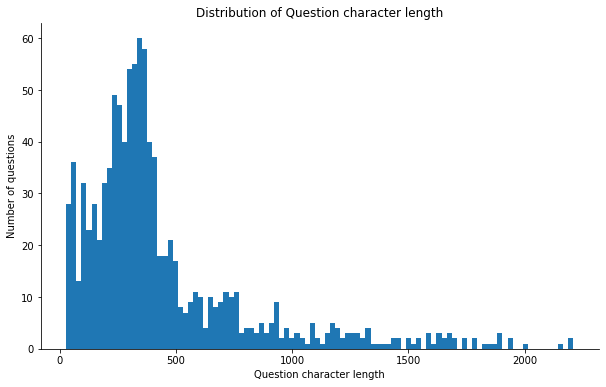

In [77]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.description]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of Question character length')
plt.ylabel('Number of questions')
plt.xlabel('Question character length')
sns.despine();

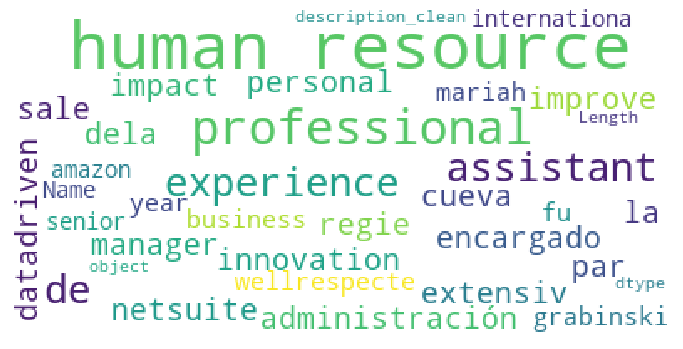

In [78]:

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['description_clean']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [79]:

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_clean['description_clean'], 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 unigrams in the question text after removing stop words and lemmatization"))
fig.show()

In [80]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_clean['description_clean'], 20)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 bigrams in the question text after removing stop words and lemmatization"))
fig.show()

In [81]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['description_clean'], 20)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 bigrams in the question text after removing stop words and lemmatization"))
fig.show()

In [42]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words='english',             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000,          
                            )

data_vectorized = vectorizer.fit_transform(df_clean['description_clean'])

lda_model = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
14     -10.878068   10.538728       1        1  34.775897
1      -60.884026  -75.591820       2        1  30.760594
7       -2.336119  -53.289074       3        1  14.000410
2      -61.385319  -12.914634       4        1   6.899189
15     -28.737743  126.296997       5        1   3.160659
10       1.066606 -123.552811       6        1   2.378754
18      45.140720   -7.947869       7        1   1.942715
4     -140.795975  -98.530548       8        1   1.306544
8       61.531681  -83.240562       9        1   0.886200
19     -72.563057 -140.396881      10        1   0.677040
5       15.984491   63.578186      11        1   0.627845
12    -160.851624   68.945145      12        1   0.501902
16      85.961830   51.922935      13        1   0.309690
6      -99.020836  109.936348      14        1   0.304974
13    -176.764130   -8.681684      15        1   0.283485
9     -117.189880  -37.420200      16        1   0.273780
17     108.829918  -22.946203      17        1   0.263340
3       47.588097  121.934814      18        1   0.234480
0     -106.467834   30.176889      19        1   0.219575
11     -50.613804   59.328842      20        1   0.192926, topic_info=              Term        Freq       Total Category  logprob  loglift
1074          sale  844.000000  844.000000  Default  30.0000  30.0000
839           nike  660.000000  660.000000  Default  29.0000  29.0000
1285    university  399.000000  399.000000  Default  28.0000  28.0000
125           base  385.000000  385.000000  Default  27.0000  27.0000
835            new  136.000000  136.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
1036  relationship    0.033622   41.673773  Topic20  -7.1887  -0.8718
1190       student    0.033618  167.413868  Topic20  -7.1888  -2.2625
532         future    0.033597   20.080211  Topic20  -7.1895  -0.1424
461     experience    0.033577  251.845796  Topic20  -7.1901  -2.6721
1127         skill    0.033572  174.274131  Topic20  -7.1902  -2.3041

[1095 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1         1  0.982126          able
6         6  0.766353     accessory
8         4  0.889173  accomplished
9         1  0.019848       account
9         2  0.714521       account
...     ...       ...           ...
1356      1  0.794730         youth
1357      2  0.577132       zealand
1357      8  0.288566       zealand
1358      1  0.573632          zone
1358     10  0.286816          zone

[1474 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 2, 8, 3, 16, 11, 19, 5, 9, 20, 6, 13, 17, 7, 14, 10, 18, 4, 1, 12])

In [43]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,supervisor,box,union,usa,james,office,study,shift,proficient,leader,register,california,lead,specifically,experience,city,support,university,work,national
Topic 1,nike,sale,base,work,university,associate,attend,study,manager,assistant,school,college,student,area,account,director,business,executive,intern,graduating
Topic 2,business,experience,management,project,planning,supply,team,operation,sale,lead,nike,skill,chain,result,strategic,development,knowledge,process,effective,year
Topic 3,test,certify,draw,practice,medical,learning,forward,month,adapt,use,assistant,college,look,learn,attend,skill,year,communicator,excel,singapore
Topic 4,south,australia,sydney,wales,new,university,assistant,unsw,clinic,tutor,francisco,president,macewan,eye,customer,vice,california,primary,waiter,dental
Topic 5,iowa,france,pay,gestion,search,production,ecole,video,esc,mission,lyc,creative,que,cole,strength,conditioning,shoot,adobe,pro,stage
Topic 6,thinking,critical,universidad,advisory,analysis,consulting,scholarship,studio,bridge,strategic,success,operation,universal,organisation,photographer,hold,design,los,require,analytical
Topic 7,sale,management,industry,professional,work,strong,demonstrate,history,experienced,business,skille,customer,good,marketing,microsoft,service,retail,sporting,university,focus
Topic 8,personal,france,trainer,paris,training,gion,communication,alexandre,marketing,digital,kid,music,gym,start,water,near,pro,listen,campus,indiana
Topic 9,universidade,wear,com,comercial,incoming,receptionist,hello,spa,rio,mall,outlet,register,floor,summer,employ,handle,past,product,store,gain


In [115]:
df[(df['has_BS'] == True) & (df['source_company'] == 'Qualcomm')].shape[0]/df[df['source_company'] == 'Qualcomm'].shape[0]

In [105]:
df = df.rename(columns={'soruce_company': 'source_company'})

In [135]:
df['has_PhD'] = df['has_PhD'].fillna(False)

In [178]:
df.iloc[:, [38]] = df.iloc[:, [27]].astype(str)
df.iloc[:, [35]]

In [164]:
df[df['source_company'] == 'Illumina']

In [52]:
df['prev_company_5'].value_counts()

Nike                                               7
IBM                                                2
Tiffany & Co.                                      2
House of Fraser                                    2
Foot Locker                                        2
                                                  ..
Weworski & Associates                              1
Freedom & Enterprise Agency                        1
Bus Stop Cafe                                      1
International Latino Cultural Center of Chicago    1
CIP Agency                                         1
Name: prev_company_5, Length: 204, dtype: int64

In [56]:
df['current_title'].value_counts()

Sales Associate                        239
Sales Assistant                         29
Sales Representative                    25
Sales Specialist                        13
Sales                                   12
                                      ... 
Student Ambassador                       1
Licensed Sales AE                        1
General Executive                        1
North America Sales Director - Golf      1
Sales Associate (Operations)             1
Name: current_title, Length: 531, dtype: int64